In [ ]:
!pip install wordcloud

In [ ]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import gzip
from urllib.request import urlopen
import spacy
from spacy import displacy
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.neural_network import MLPClassifier
from collections import Counter
from imblearn.under_sampling import NearMiss

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
#this code and code in following three cells from source 1 below
data=[]

with open("Pet_Supplies_5.json","r") as f:
    for l in f:
            data.append((json.loads(l.strip())))

In [ ]:
df = pd.DataFrame.from_dict(data)

In [ ]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,3.0,2,True,"12 2, 2016",A2KN4FJVI2TZSF,0972585419,M.G.,I purchased this cd for my Pocket Parrot. It h...,It's okay,1480636800,NaN,NaN
1,3.0,NaN,True,"10 17, 2016",A3RMA1DD66JDRV,0972585419,Susan P.,"Maybe it's just my Amazon parrot, but she's no...",It might work for a different bird,1476662400,NaN,NaN
2,5.0,2,True,"09 9, 2016",AAANYRIEOIT3R,0972585419,Luggie Lugnut,I bought this to help me teach my blue quaker ...,I bought this to help me teach my blue quaker ...,1473379200,NaN,NaN
3,3.0,NaN,True,"08 31, 2016",A3W44VX0LXAOHU,0972585419,Melissa Partin,Bird showed no interest in it....,Three Stars,1472601600,NaN,NaN
4,2.0,NaN,True,"08 18, 2016",A16ZDBZGKYDRSU,0972585419,Cheryle Bell,Didn't do a thing for my African Grey! He hate...,He hated it and it was very obnoxious,1471478400,NaN,NaN


In [ ]:
#only keeping overall and reviewtext columns
df=df[['overall','reviewText']]

In [ ]:
#make overall a binary column
df['score']=np.where(df['overall'].isin([1,2,3]),1,0)

<ipython-input-62-a2ba53ab23ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score']=np.where(df['overall'].isin([1,2,3]),1,0)


In [ ]:
df.head(10)

,overall,reviewText,score
0,3.0,I purchased this cd for my Pocket Parrot. It h...,1
1,3.0,"Maybe it's just my Amazon parrot, but she's no...",1
2,5.0,I bought this to help me teach my blue quaker ...,0
3,3.0,Bird showed no interest in it....,1
4,2.0,Didn't do a thing for my African Grey! He hate...,1
5,4.0,I like it - but the Cockatiel I am not so sure...,0
6,3.0,"This is a CD. I should have read better, I was...",1
7,5.0,my parot loves this CD! started repeating the ...,0
8,5.0,Good,0
9,1.0,I was reLly disappointed the cd has a lot of s...,1


In [ ]:
df.groupby('overall')['overall'].count()
# most reviews are five stars

overall
1.0     118514
2.0      97852
3.0     164671
4.0     266869
5.0    1281136
Name: overall, dtype: int64

In [ ]:
(1281136+266869)/len(df)
#80% of reviews are 4 and 5 star reviews

0.8024734557360597

In [ ]:
#had to cut down a lot to get it to run in a reasonable amount of time
df_sample=df.sample(n=25000)

In [ ]:
#check sample distribution
sample_freq=df_sample.groupby(['overall']).count().reset_index()

In [ ]:
sample_freq

,overall,reviewText,score
0,1.0,1574,1574
1,2.0,1291,1291
2,3.0,2131,2131
3,4.0,3454,3455
4,5.0,16538,16549


In [ ]:
# sample 4 and 5 stars

(3455+16549)/len(df_sample)

0.80016

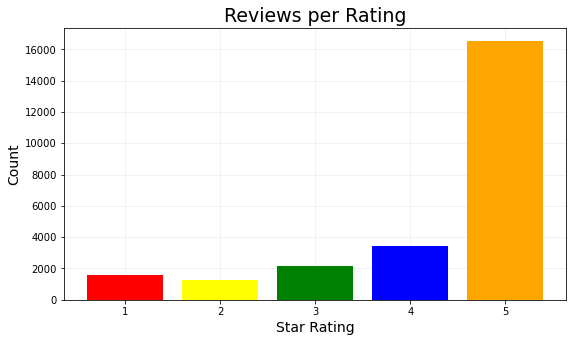

In [ ]:
#visualizing the distribution

plt.figure(figsize=(9,5))

colors=['red', 'yellow', 'green', 'blue', 'orange']

plt.bar(sample_freq['overall'], sample_freq['reviewText'],
        color=colors,
       zorder=3)

plt.xticks([1,2,3,4,5])
plt.title('Reviews per Rating', fontsize=19)
plt.xlabel('Star Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.grid(zorder=0,
        which='major',
        alpha=.2)



plt.show()

In [ ]:
#lemmatization

from nltk.corpus import wordnet

#the below code comes from source 2

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
lemmatizer=WordNetLemmatizer()

In [ ]:
#initiate lemmatizer
lemmatizer.lemmatize('dogs')

'dog'

In [ ]:
#import main stopwords
from nltk.corpus import stopwords
nltk_stopwords = set(stopwords.words('english'))

In [ ]:
#define cleaning (mostly from class)
def clean(corpus, pattern):
    cleaned_reviews=[]
    word_list=[]
    for review in corpus:
        words = re.findall(pattern, str(review))
        new_words = []
        for word in words:
            word=lemmatizer.lemmatize (word, get_wordnet_pos(word)) # add in lemmatization
            word=word.lower()
            if word in nltk_stopwords:
                continue
            new_words.append(word)
            word_list.append(word)
        cleaned_review = " ".join(new_words)
        cleaned_reviews.append(cleaned_review)
    return cleaned_reviews

In [ ]:
#save cleaned text
cleaned_corp=clean(df_sample['reviewText'],pattern)

In [ ]:
#look for additional stopwords:
Counter(word_list).most_common(20)

[('dog', 4334),
 ('love', 2788),
 ('cat', 2450),
 ('get', 2187),
 ('use', 2059),
 ('one', 2010),
 ('great', 1909),
 ('like', 1896),
 ('well', 1657),
 ('work', 1380),
 ('product', 1363),
 ('good', 1270),
 ('would', 1231),
 ('food', 1225),
 ('make', 1162),
 ('go', 1072),
 ('small', 1017),
 ('time', 1009),
 ('toy', 1004),
 ('really', 883)]

In [ ]:
#list of additional stop words
add_stop_words=['use','one','go']

In [ ]:
#additional stopword removal

cleaned_reviews2 = []

for review in cleaned_reviews:
    words = review.split()
    new_words = []
    for word in words:
        word=word.lower()
        if word in add_stop_words:
            continue
        new_words.append(word)
    cleaned_review = " ".join(new_words)
    cleaned_reviews2.append(cleaned_review)

In [ ]:
#oversampling to address class imbalance
import imblearn
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(random_state=42)


x_ros, y_ros=ros.fit_resample((np.array(cleaned_corp).reshape(-1,1)), df_sample['score'])

In [ ]:
#check
y_ros.mean()

0.5

In [ ]:
#put cleaned data in dataframe
cleaned_data=pd.DataFrame(columns=['Review','Negative'], index=range(0,len(x_ros)))
cleaned_data['Review']=x_ros
cleaned_data['Negative']=y_ros

In [ ]:
#preview
cleaned_data

,Review,Negative
0,pet need natural stuff smell great safe use ar...,0
1,excellent,0
2,works great easy use clean,0
3,harness impossible get dog correctly,1
4,electronic door dog work great let need go dau...,0
...,...,...
40003,impossible insulate single pane insulation wor...,1
40004,bet brand good food dog like taste kibble bite...,1
40005,kind work kind,1
40006,work really hard make sure hen duck healthy di...,1


In [ ]:
#then export clean data
cleaned_data.to_csv('pet_data_clean.csv')

## EDA

In [ ]:
#intersted in words associated with negative reviews
#create df with just negative reviews
neg_data=cleaned_data.loc[cleaned_data['Negative']==1,:]

In [ ]:
neg_words=[]

for review in cleaned_data['Review']:
        words = review.split()
        for word in words:
            neg_words.append(word)
            

In [ ]:
top_30=Counter(neg_words).most_common(30)

In [ ]:
top_30=[i[0] for i in top_30]

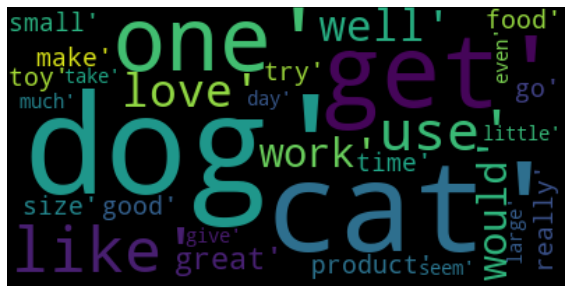

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(str(top_30))


plt.figure(figsize=(10,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

Sources:

Source 1: https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV#scrollTo=knpHP22w4scK

Source 2: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/